In [1]:
import pandas as pd
import numpy as np
import math
from datetime import timezone, datetime, timedelta

import geopandas as gpd

import matplotlib.pyplot as plt
from pandas.plotting._matplotlib.style import get_standard_colors
import matplotlib.dates as mdates

import contextily as ctx
from rasterio.crs import CRS

from pyproj import Geod

In [2]:
print(pd. __version__) 

1.3.1


In [3]:
df_dev1 = pd.read_csv('./europa_filtered_gnss_tracker_data_bkp20210810/from_influxdb_storage/gnss_data_europa2021_filtrssi_tracker0_influxdb.csv', sep=',', header=0)
df_dev2 = pd.read_csv('./europa_filtered_gnss_tracker_data_bkp20210810/from_influxdb_storage/gnss_data_europa2021_filtrssi_tracker1_influxdb.csv', sep=',', header=0)
df_dev3 = pd.read_csv('./europa_filtered_gnss_tracker_data_bkp20210810/from_influxdb_storage/gnss_data_europa2021_filtrssi_tracker2_influxdb.csv', sep=',', header=0)

df_gtw = pd.read_csv('Suivi_info_gateway_tortue.csv', sep=',', header=0)

In [4]:
df_dev1.head()

time            DevEUI  FCount  FPort  \
0  2021-01-17 01:34:12+00:00  383434304e377f0a    3598    103   
1  2021-01-17 01:36:11+00:00  383434304e377f0a    3599    103   
2  2021-01-17 01:38:10+00:00  383434304e377f0a    3600    103   
3  2021-01-17 01:40:09+00:00  383434304e377f0a    3601    103   
4  2021-01-17 01:42:08+00:00  383434304e377f0a    3602    103   

                                                Meta  \
0  {"applicationID":"1","applicationName":"Keloni...   
1  {"applicationID":"1","applicationName":"Keloni...   
2  {"applicationID":"1","applicationName":"Keloni...   
3  {"applicationID":"1","applicationName":"Keloni...   
4  {"applicationID":"1","applicationName":"Keloni...   

                                            Payload      Source  \
0  9f87aef2a4770b18ed9c0200320f00000000000009000000  ChirpStack   
1  b8c2aef279690a18fcce130096860100000000000c000000  ChirpStack   
2  e087aef2e8750b18675f0700740e0000000000000d000000  ChirpStack   
3  9687aef208780b18f2910200000a00000000000011000000  ChirpStack   
4  1488aef28a730b1879530200ce0900000000000013000000  ChirpStack   

                               UplinkId   latitude  longitude      ehpe  \
0  00000000-0000-0000-0000-000000000000 -22.344304  40.340471   171.245   
1  00000000-0000-0000-0000-000000000000 -22.342791  40.333554  1298.172   
2  00000000-0000-0000-0000-000000000000 -22.344298  40.340426   483.175   
3  00000000-0000-0000-0000-000000000000 -22.344305  40.340481   168.434   
4  00000000-0000-0000-0000-000000000000 -22.344292  40.340366   152.441   

    hdop  ttf  nbSat  noFixCount  zeroSatTimeout  rssi  loraSNR gatewayID  
0   3890    0      9           0               0   -70       12      Main  
1  99990    0     12           0               0   -69       12      Main  
2   3700    0     13           0               0   -70       12      Main  
3   2560    0     17           0               0   -73       12      Main  
4   2510    0     19           0               0   -69        8      Main

In [5]:
df_dev1['gatewayID']=df_dev1['gatewayID'].str.lower()
df_dev2['gatewayID']=df_dev2['gatewayID'].str.lower()
df_dev3['gatewayID']=df_dev3['gatewayID'].str.lower()
df_gtw['Pseudo']=df_gtw['Pseudo'].str.lower()

In [6]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df1 = df_dev1.filter(['time','FCount','latitude','longitude','ehpe','rssi','loraSNR','gatewayID'],axis=1)
df2 = df_dev2.filter(['time','FCount','latitude','longitude','ehpe','rssi','loraSNR','gatewayID'],axis=1)
df3 = df_dev3.filter(['time','FCount','latitude','longitude','ehpe','rssi','loraSNR','gatewayID'],axis=1)

#df1['time'] = pd.to_datetime(df1['time'])
#df2['time'] = pd.to_datetime(df2['time'])
#df3['time'] = pd.to_datetime(df3['time'])

df1['time'] = df1['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S+00:00'))
df1['time'] = pd.to_datetime(df1['time'])
df2['time'] = df2['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S+00:00'))
df2['time'] = pd.to_datetime(df2['time'])
df3['time'] = df3['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S+00:00'))
df3['time'] = pd.to_datetime(df3['time'])

df1.drop(df1.index[df1['rssi']>0], inplace = True)
df2.drop(df2.index[df2['rssi']>0], inplace = True)
df3.drop(df3.index[df3['rssi']>0], inplace = True)

df1 = pd.merge(df1,df_gtw[['short ID', 'Pseudo', 'Longitude', 'Latitude']],left_on='gatewayID',right_on='Pseudo', how='left').drop('Pseudo', axis=1)
df2 = pd.merge(df2,df_gtw[['short ID', 'Pseudo', 'Longitude', 'Latitude']],left_on='gatewayID',right_on='Pseudo', how='left').drop('Pseudo', axis=1)
df3 = pd.merge(df3,df_gtw[['short ID', 'Pseudo', 'Longitude', 'Latitude']],left_on='gatewayID',right_on='Pseudo', how='left').drop('Pseudo', axis=1)

df1 = df1.rename(columns={"latitude": "objlat", "longitude": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "short ID":"shortIdGateway"})
df2 = df2.rename(columns={"latitude": "objlat", "longitude": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "short ID":"shortIdGateway"})
df3 = df3.rename(columns={"latitude": "objlat", "longitude": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "short ID":"shortIdGateway"})

#df1.set_index(['time','gatewayID'], inplace=True)
#df2.set_index(['time','gatewayID'], inplace=True)
#df3.set_index(['time','gatewayID'], inplace=True)

df1.head()

time  FCount     objlat     objlng      ehpe  rssi  loraSNR  \
0 2021-01-17 01:34:12    3598 -22.344304  40.340471   171.245   -70       12   
1 2021-01-17 01:36:11    3599 -22.342791  40.333554  1298.172   -69       12   
2 2021-01-17 01:38:10    3600 -22.344298  40.340426   483.175   -70       12   
3 2021-01-17 01:40:09    3601 -22.344305  40.340481   168.434   -73       12   
4 2021-01-17 01:42:08    3602 -22.344292  40.340366   152.441   -69        8   

  gatewayID  shortIdGateway  gatewaylng  gatewaylat  
0      main               0   40.340192  -22.343807  
1      main               0   40.340192  -22.343807  
2      main               0   40.340192  -22.343807  
3      main               0   40.340192  -22.343807  
4      main               0   40.340192  -22.343807

In [7]:
gdf1 = gpd.GeoDataFrame(df1, crs = "EPSG:4326", geometry=gpd.points_from_xy(df1['objlng'], df1['objlat']))
gdf2 = gpd.GeoDataFrame(df2, crs = "EPSG:4326", geometry=gpd.points_from_xy(df2['objlng'], df2['objlat']))
gdf3 = gpd.GeoDataFrame(df3, crs = "EPSG:4326", geometry=gpd.points_from_xy(df3['objlng'], df3['objlat']))

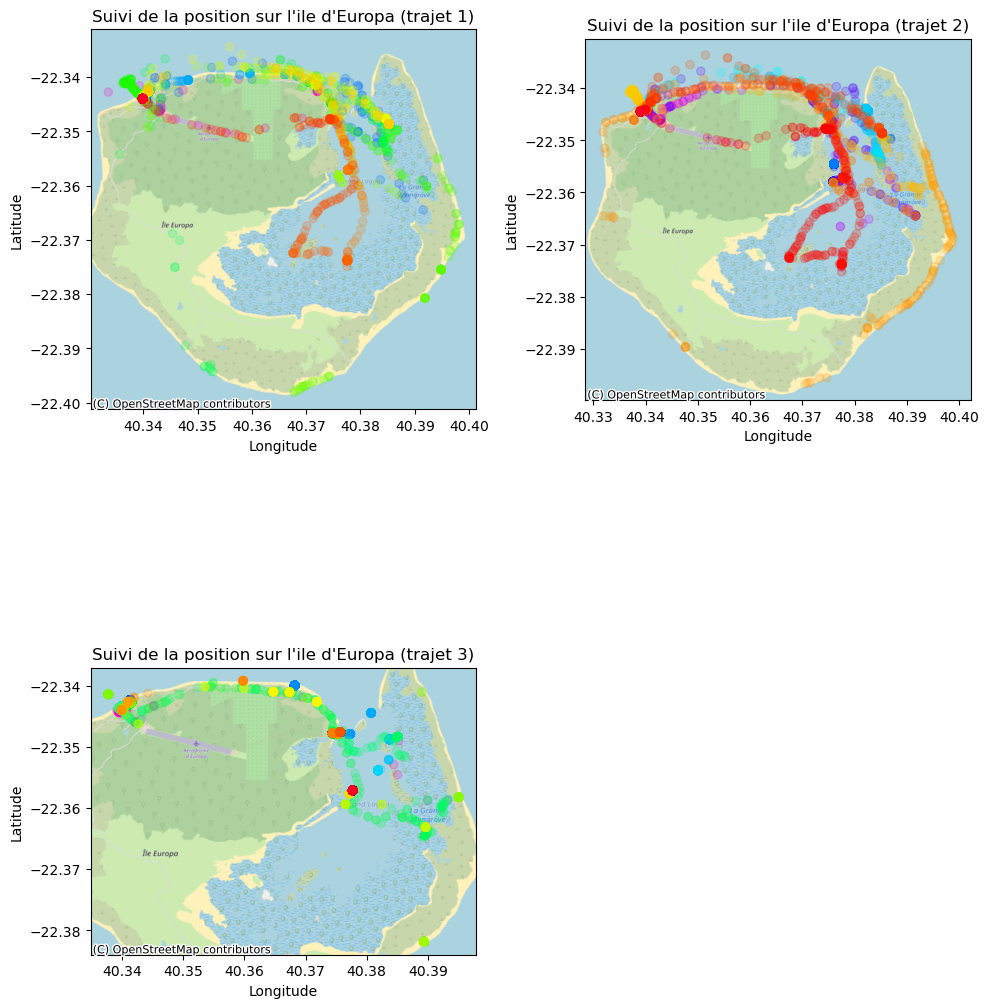

In [8]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2,ncols=2, figsize=(10,12))
gdf1.plot(ax=ax1,zorder=2,alpha=0.2,c=gdf1['rssi'], cmap='gist_rainbow_r',label="objet", legend=True)
ctx.add_basemap(ax1, crs=gdf1.crs, reset_extent=True,source=ctx.providers.OpenStreetMap.Mapnik)

gdf2.plot(ax=ax2,zorder=2,alpha=0.2,c=gdf2['rssi'], cmap='gist_rainbow_r',label="objet", legend=True)
ctx.add_basemap(ax2, crs=gdf2.crs, reset_extent=True,source=ctx.providers.OpenStreetMap.Mapnik)

gdf3.plot(ax=ax3,zorder=2,alpha=0.2,c=gdf3['rssi'], cmap='gist_rainbow_r',label="objet", legend=True)
ctx.add_basemap(ax3, crs=gdf3.crs, reset_extent=True,source=ctx.providers.OpenStreetMap.Mapnik)


ax1.set_title('Suivi de la position sur l\'ile d\'Europa (trajet 1)')
ax1.set(xlabel="Longitude", ylabel="Latitude")
ax2.set_title('Suivi de la position sur l\'ile d\'Europa (trajet 2)')
ax2.set(xlabel="Longitude", ylabel="Latitude")
ax3.set_title('Suivi de la position sur l\'ile d\'Europa (trajet 3)')
ax3.set(xlabel="Longitude", ylabel="Latitude")

#TODO : colorbar
fig.delaxes(ax4)
plt.tight_layout()
plt.show()

In [9]:
wgs84_geod = Geod(ellps='WGS84')

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

#Distance en mètre
df1['distancegps'] = Distance(df1['gatewaylat'].tolist(),df1['gatewaylng'].tolist(),df1['objlat'].tolist(),df1['objlng'].tolist())
df2['distancegps'] = Distance(df2['gatewaylat'].tolist(),df2['gatewaylng'].tolist(),df2['objlat'].tolist(),df2['objlng'].tolist())
df3['distancegps'] = Distance(df3['gatewaylat'].tolist(),df3['gatewaylng'].tolist(),df3['objlat'].tolist(),df3['objlng'].tolist())

In [27]:
def plot_multi(data, ax, cols=None, title=None, xlabel=None,spacing=.1, **kwargs):

    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = get_standard_colors(num_colors=len(cols))

    # First axis
    #ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    data.plot(ax=ax,x='time', y=cols[0], label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    if title is not None : ax.set_title(title)
    if xlabel is not None : ax.set_xlabel(xlabel=xlabel)
    lines, labels = ax.get_legend_handles_labels()
    

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.plot(ax=ax_new, x='time', y=cols[n], label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])
       
        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    #ax.legend(lines, labels, loc=0)
    return ax

In [28]:
def func(data, cols=None, titlefig=None, nrows=1, ncols=1, spacing=.1, **kwargs):
    grouped = data.groupby('gatewayID')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    if titlefig is not None : fig.suptitle(str(titlefig), fontsize=16)
    
    if len(axes) == 0 : return
    for (key, ax) in zip(grouped.groups.keys(), axes):
        tmp = pd.DataFrame(grouped.get_group(key))
        title='gateway=%s'%str(key)
        plot_multi(tmp, ax=ax, cols=cols, title=title, xlabel='date', spacing=spacing, **kwargs)      
    return ax

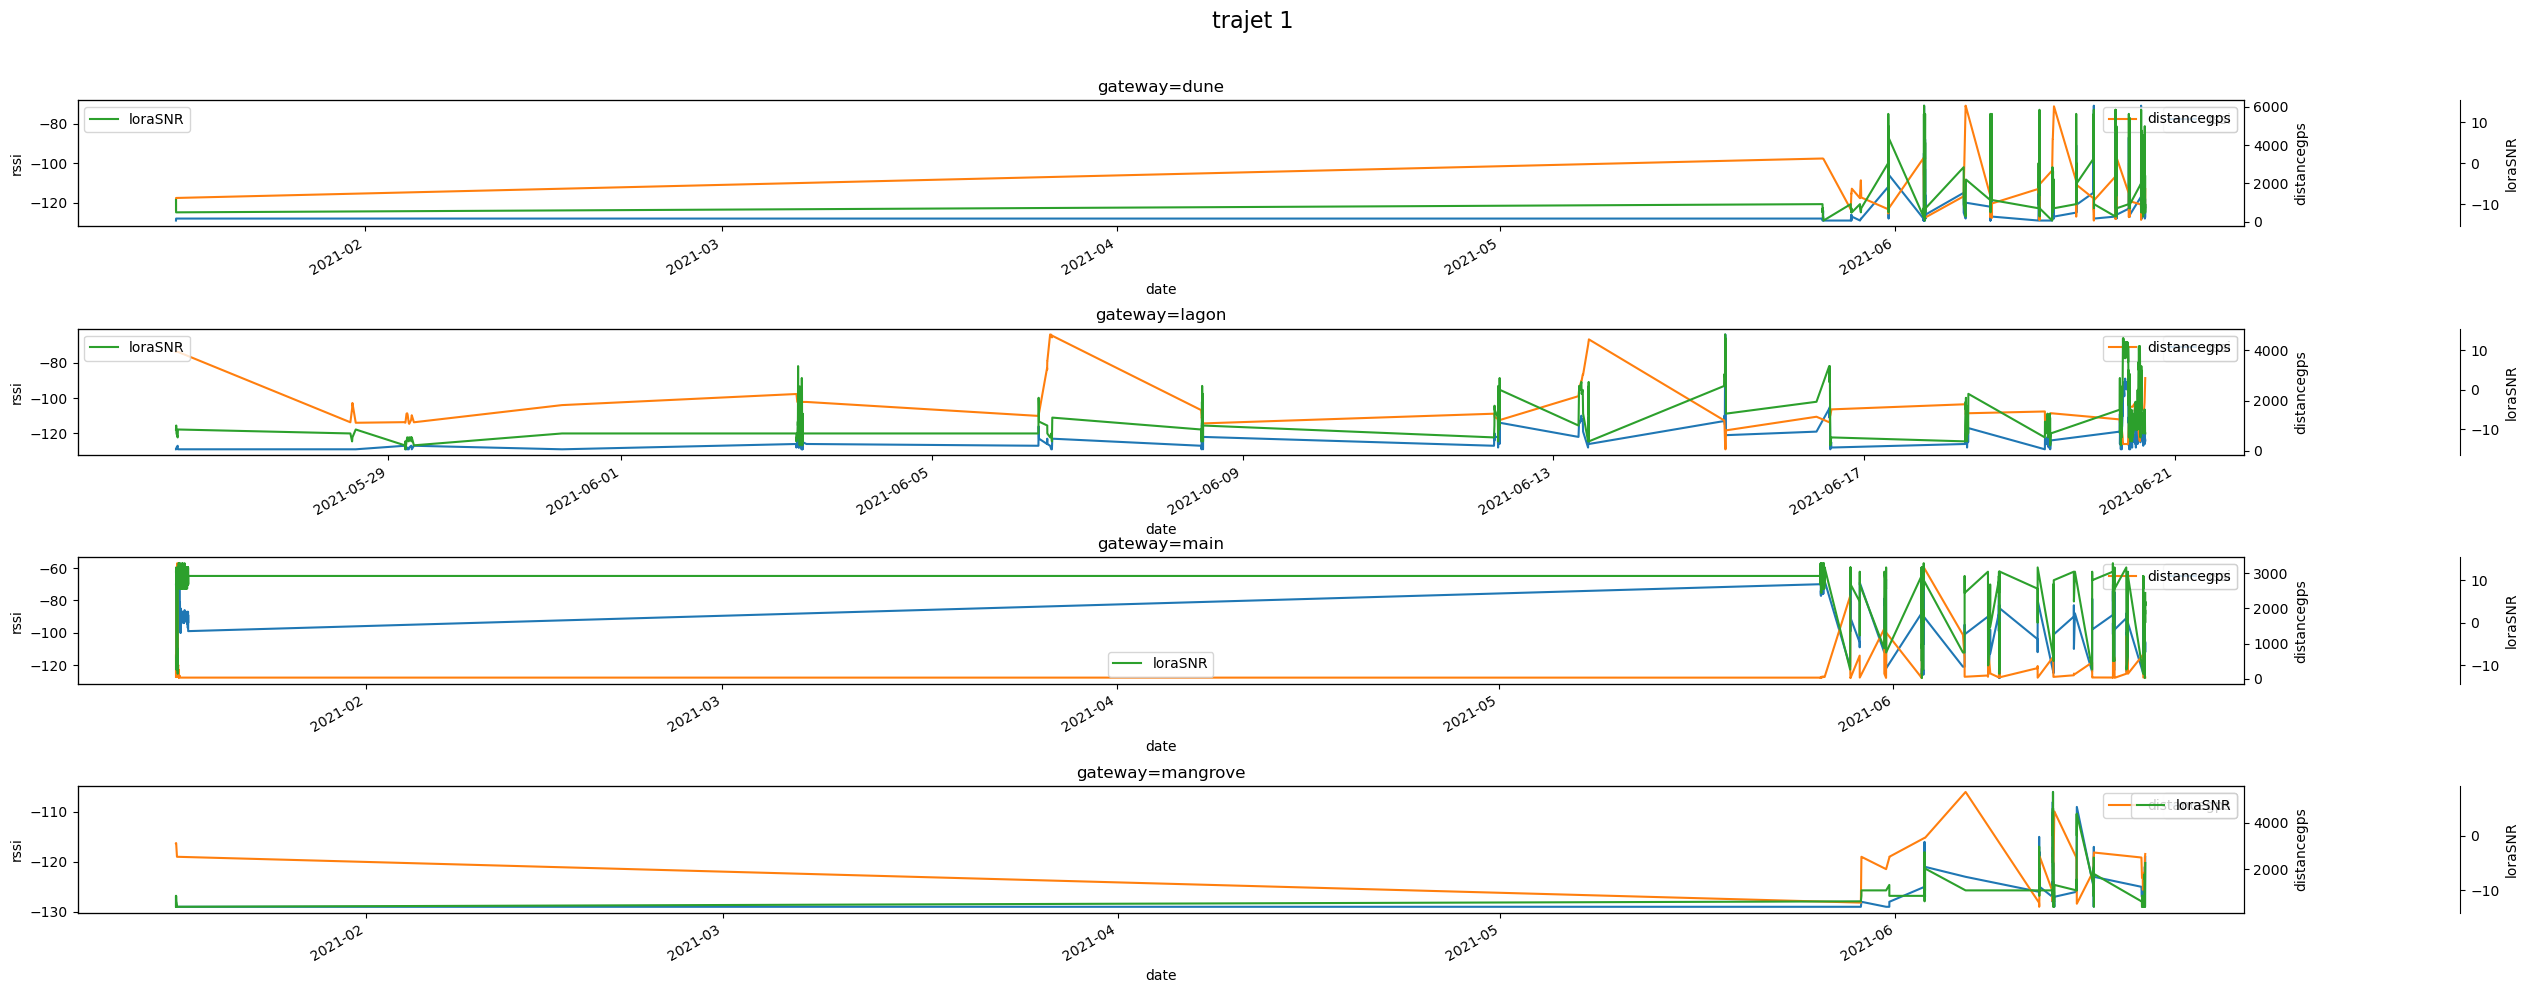

In [29]:
ax = func(df1, cols=['rssi','distancegps','loraSNR'], titlefig='trajet 1',nrows=4, figsize=(25,10))

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.89)
plt.show()

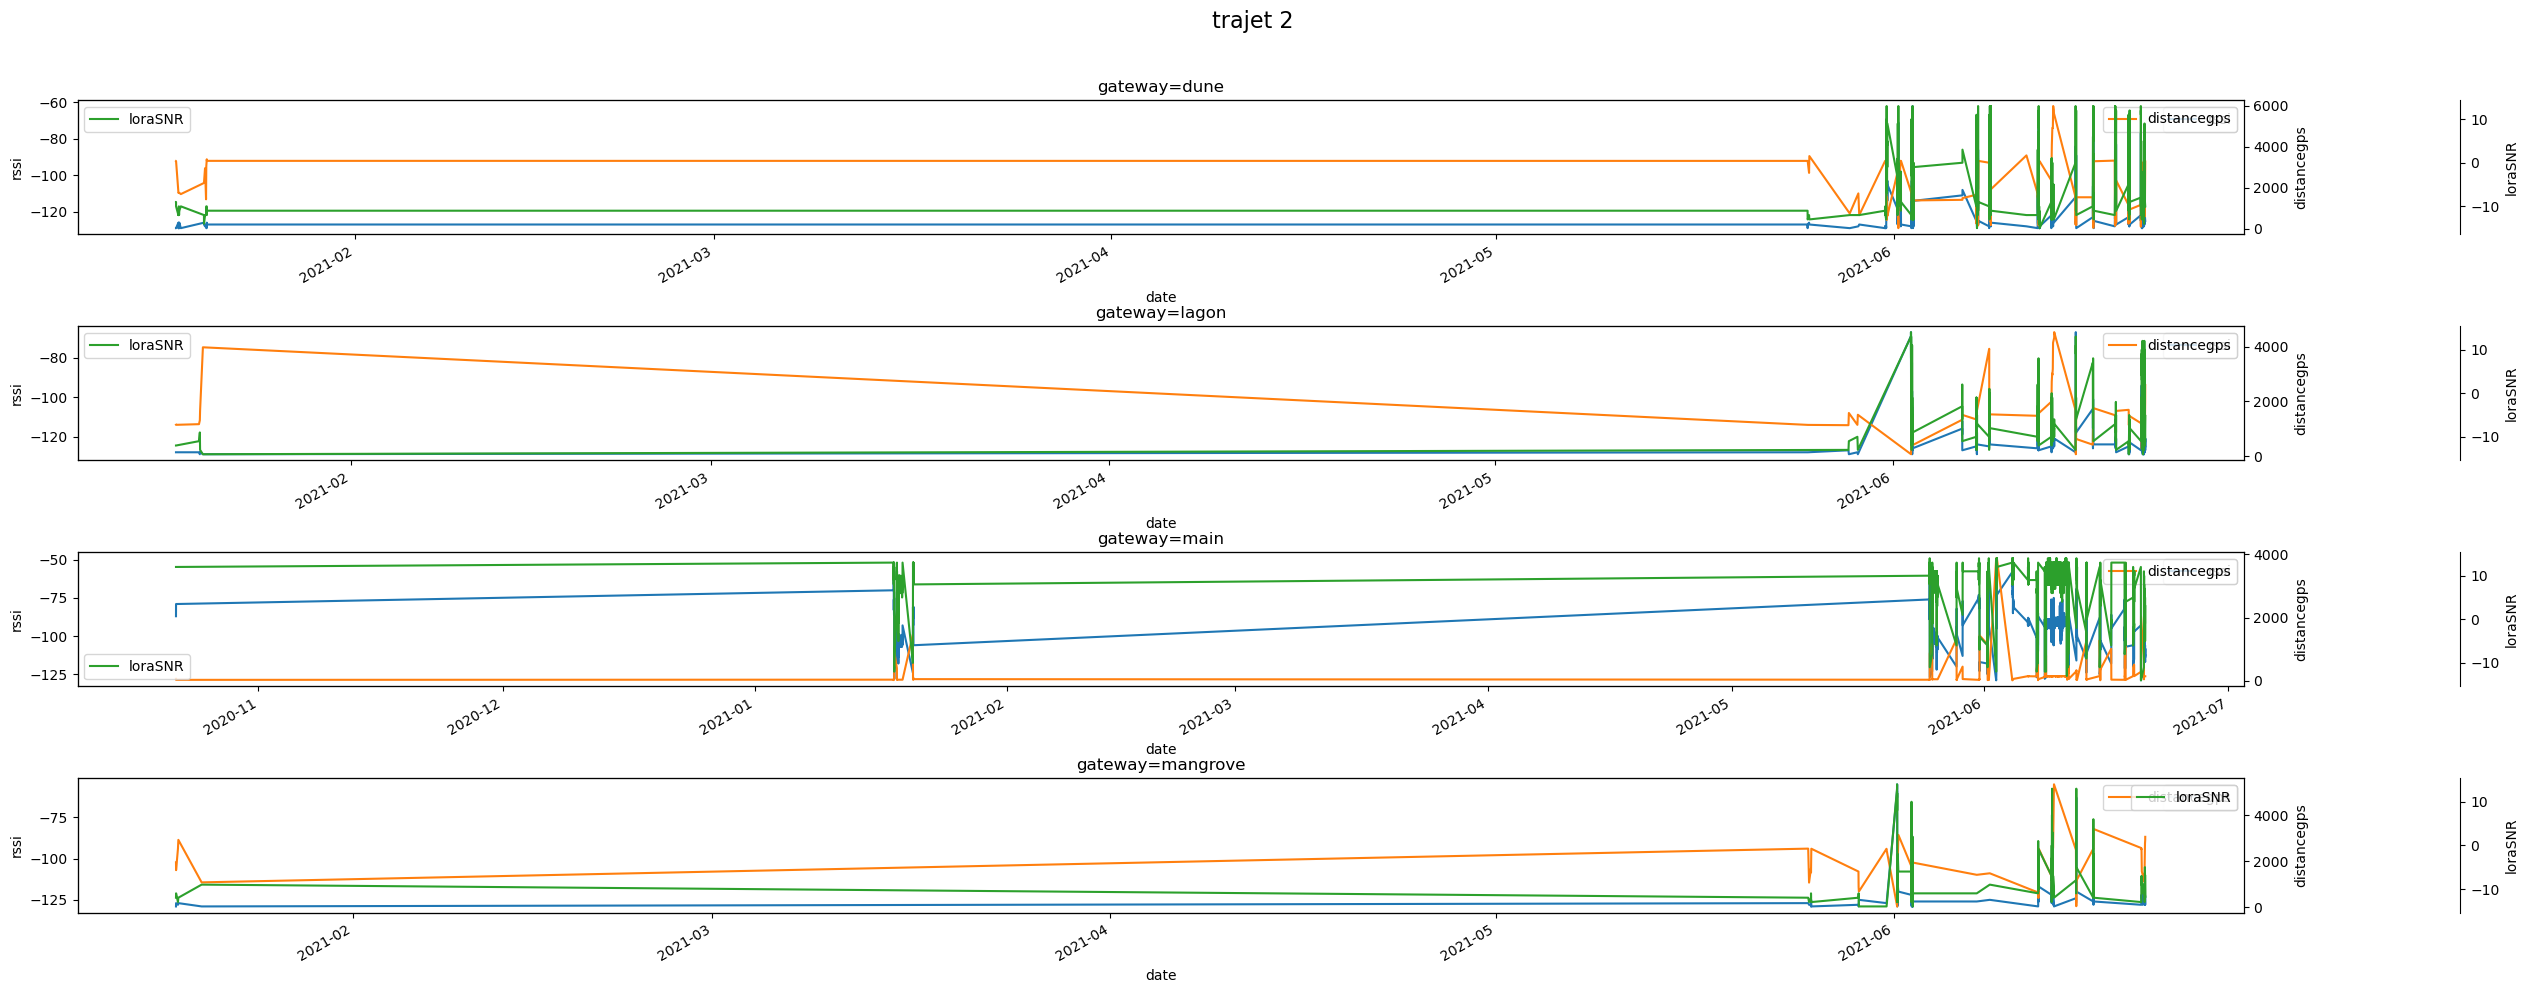

In [30]:
ax = func(df2, cols=['rssi','distancegps','loraSNR'], titlefig='trajet 2',nrows=4, figsize=(25,10))

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.89)
plt.show()

In [31]:
ax = func(df3, cols=['rssi','distancegps','loraSNR'], titlefig='trajet 3',nrows=4, figsize=(25,10))

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.89)
plt.show()

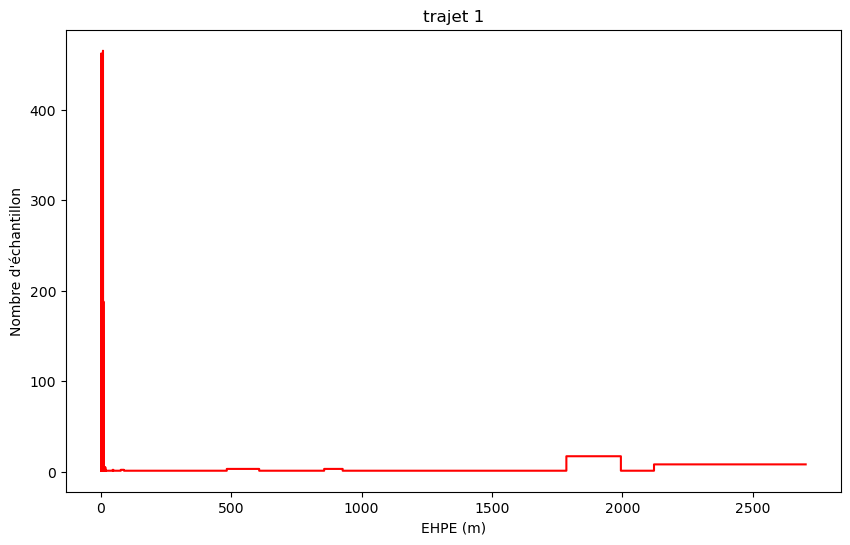

In [17]:
ehpeDf1 = df1\
.groupby('ehpe')['rssi']\
.agg('count')\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'count'}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
plt.step(ehpeDf1['ehpe'], ehpeDf1['count'], color="red")
plt.xlabel("EHPE (m)")
plt.ylabel("Nombre d'échantillon")
ax.set_title('trajet 1')
plt.show()

In [18]:
np.percentile(df1['ehpe'], [25, 50, 75, 95])

array([ 2.33075,  3.1025 ,  8.556  , 12.32965])

In [19]:
ehpeDf2 = df2\
.groupby('ehpe')['rssi']\
.agg('count')\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'count'}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
plt.step(ehpeDf2['ehpe'], ehpeDf2['count'], color="red")
plt.xlabel("EHPE (m)")
plt.ylabel("Nombre d'échantillon")
ax.set_title('trajet 2')
plt.show()

In [20]:
np.percentile(df2['ehpe'], [25, 50, 75, 95])

array([ 2.517,  3.212,  4.559, 60.951])

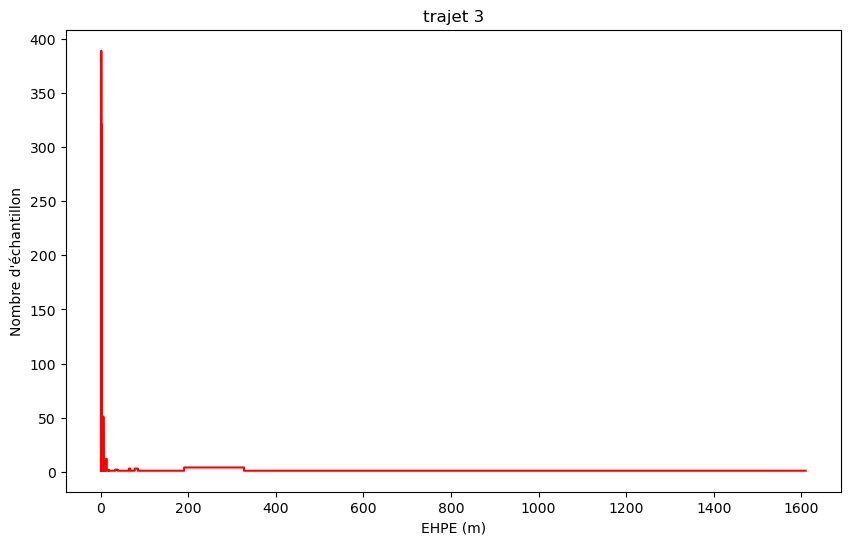

In [21]:
ehpeDf3 = df3\
.groupby('ehpe')['rssi']\
.agg('count')\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'count'}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
plt.step(ehpeDf3['ehpe'], ehpeDf3['count'], color="red")
plt.xlabel("EHPE (m)")
plt.ylabel("Nombre d'échantillon")
ax.set_title('trajet 3')
plt.show()

In [22]:
np.percentile(df3['ehpe'], [25, 50, 75, 95])

array([1.39 , 1.631, 2.177, 5.973])

In [23]:
statsPdfCdfDf1 = df1 \
.reset_index()\
.groupby('distancegps') \
['distancegps'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'distancegps': 'frequency'})\

# PDF
statsPdfCdfDf1['pdf'] = statsPdfCdfDf1['frequency'] / sum(statsPdfCdfDf1['frequency'])

# CDF
statsPdfCdfDf1['cdf'] = statsPdfCdfDf1['pdf'].cumsum()
statsPdfCdfDf1 = statsPdfCdfDf1.reset_index()


fig,ax1 = plt.subplots(figsize=(10,6))
statsPdfCdfDf1.plot(ax=ax1, x='distancegps', y='cdf')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('Probabilité cumulative')
ax1.set_title('trajet 1')

ax2 = ax1.twinx()
statsPdfCdfDf1.plot(ax=ax2, x='distancegps', y='pdf',style='orange')
ax2.set_ylabel('Densité')

plt.show()

In [24]:
statsPdfCdfDf2 = df2 \
.reset_index()\
.groupby('distancegps') \
['distancegps'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'distancegps': 'frequency'})\

# PDF
statsPdfCdfDf2['pdf'] = statsPdfCdfDf2['frequency'] / sum(statsPdfCdfDf2['frequency'])

# CDF
statsPdfCdfDf2['cdf'] = statsPdfCdfDf2['pdf'].cumsum()
statsPdfCdfDf2 = statsPdfCdfDf2.reset_index()

fig,ax1 = plt.subplots(figsize=(10,6))
statsPdfCdfDf2.plot(ax=ax1, x='distancegps', y='cdf')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('Probabilité cumulative')
ax1.set_title('trajet 2')

ax2 = ax1.twinx()
statsPdfCdfDf2.plot(ax=ax2, x='distancegps', y='pdf',style='orange')
ax2.set_ylabel('Densité')

plt.show()

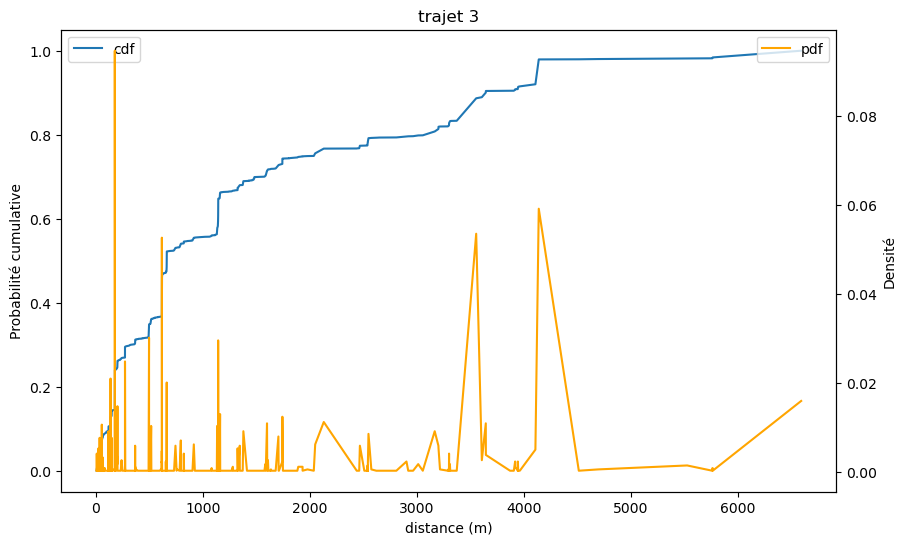

In [25]:
statsPdfCdfDf3 = df3 \
.reset_index()\
.groupby('distancegps') \
['distancegps'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'distancegps': 'frequency'})\

# PDF
statsPdfCdfDf3['pdf'] = statsPdfCdfDf3['frequency'] / sum(statsPdfCdfDf3['frequency'])

# CDF
statsPdfCdfDf3['cdf'] = statsPdfCdfDf3['pdf'].cumsum()
statsPdfCdfDf3 = statsPdfCdfDf3.reset_index()

fig,ax1 = plt.subplots(figsize=(10,6))
statsPdfCdfDf3.plot(ax=ax1, x='distancegps', y='cdf')
ax1.set_xlabel('distance (m)')
ax1.set_ylabel('Probabilité cumulative')
ax1.set_title('trajet 3')

ax2 = ax1.twinx()
statsPdfCdfDf3.plot(ax=ax2, x='distancegps', y='pdf',style='orange')
ax2.set_ylabel('Densité')

plt.show()

In [26]:
#polar